In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from team36.mnist.vgg import VGG
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet

DIR = '.'
DATA_DIR = f'{DIR}/data'

training_set = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
                                          transform=transforms.ToTensor())

prev_model = VGG()
state_dict = torch.load(f"{DIR}/checkpoints/mnist-vgg.pth", map_location=torch.device('cpu'))
prev_model.load_state_dict(state_dict)
prev_criterion = nn.CrossEntropyLoss()

attack_training_set = FastSignGradientAttackDataSet(training_set, prev_model, prev_criterion, 
                                                    epsilon=0.25)
indices = torch.randperm(len(attack_training_set))[:int(len(attack_training_set) * 0.1)]
attack_training_set = torch.utils.data.Subset(attack_training_set, indices)

combined_training_set = torch.utils.data.ConcatDataset([training_set, attack_training_set])

training_indices, validation_indices = train_test_split(
    range(len(combined_training_set)),
    test_size=0.1,
)
training_split = torch.utils.data.Subset(combined_training_set, training_indices)
validation_split = torch.utils.data.Subset(combined_training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")

59400 in training set
6600 in validation set


Epoch: [0][0/4]	Loss 2.4570 (2.4570)	Prec @1 0.0938 (0.0938)	
Epoch 0 | Training accuracy: 0.2070000022649765% | Validation accuracy: 0.16803030669689178%
Epoch: [1][0/4]	Loss 14.5787 (14.5787)	Prec @1 0.1289 (0.1289)	
Epoch 1 | Training accuracy: 0.36800000071525574% | Validation accuracy: 0.15121212601661682%
Epoch: [2][0/4]	Loss 8.5661 (8.5661)	Prec @1 0.1484 (0.1484)	
Epoch 2 | Training accuracy: 0.29499998688697815% | Validation accuracy: 0.23424242436885834%


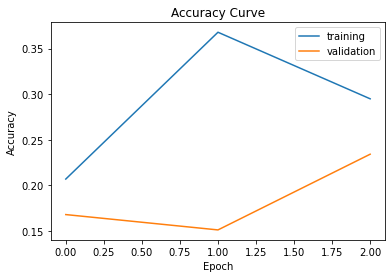

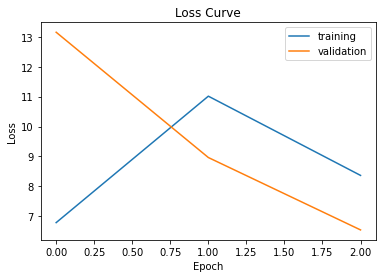

Best Validation Acccuracy: 0.2342


In [36]:
from team36.mnist.vgg import VGG
from team36.training import train, validate

learning_rate = 5e-3
momentum = 5e-1
weight_decay = 5e-2
batch_size = 256
epochs = 3

sampler = torch.utils.data.RandomSampler(training_split, replacement=True, num_samples=1000)
training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, sampler=sampler)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=100, shuffle=False)

model = VGG()
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)

best = 0.0
best_cm = None
best_model = None
train_accuracy_history = []
train_loss_history = []
validation_accuracy_history = []
validation_loss_history = []
for epoch in range(epochs):
    train_acc, train_loss = train(epoch, training_loader, model, optimizer, criterion)
    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    acc, cm, loss = validate(epoch, test_loader, model, criterion)
    validation_accuracy_history.append(acc)
    validation_loss_history.append(loss)
    
    print("Epoch {0} | Training accuracy: {1}% | Validation accuracy: {2}%".format(epoch, train_acc, acc))
    
    if acc > best:
        best = acc
        best_cm = cm
        best_model = copy.deepcopy(model)
        
training_curve, = plt.plot(train_accuracy_history, label='training')
validation_curve, = plt.plot(validation_accuracy_history, label='validation')
plt.title('Accuracy Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

training_curve, = plt.plot(train_loss_history, label='training')
validation_curve, = plt.plot(validation_loss_history, label='validation')
plt.title('Loss Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Best Validation Acccuracy: {:.4f}'.format(best))